In [1]:
#!pip install --upgrade setuptools pip --user
#!pip install onnx 
#!pip install onnxruntime
#!pip install --ignore-installed PyYAML
#!pip install Pillow

#!pip install protobuf<4.21.3
#!pip install onnxruntime-gpu
#!pip install onnx>=1.9.0
#!pip install onnx-simplifier>=0.3.6 --user

In [2]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0], sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0) 
Pytorch version: 1.12.1+cu102 


/home/pjvazquez/anaconda3/envs/trackintst/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!nvidia-smi

Tue Oct 18 10:04:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:01:00.0 Off |                  N/A |
| 33%   46C    P0    44W / 180W |    967MiB /  8119MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!# Download YOLOv7 code
# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7
# !ls

In [5]:
!# Download trained weights
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [6]:
!pwd

/mnt/PROJECTS/TrackIn/yolov7/tools


In [7]:
!python /mnt/PROJECTS/TrackIn/yolov7/detect.py --weights /mnt/PROJECTS/TrackIn/yolov7/trained_weights/yolov7.pt --conf 0.25 --img-size 640 --source /mnt/PROJECTS/TrackIn/yolov7/inference/images/IMG-1-01.png

Namespace(weights=['/mnt/PROJECTS/TrackIn/yolov7/trained_weights/yolov7.pt'], source='/mnt/PROJECTS/TrackIn/yolov7/inference/images/IMG-1-01.png', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu102 CUDA:0 (GeForce GTX 1080, 8119.5625MB)

Download error: [Errno 2] No such file or directory: '/mnt/projects/trackin/yolov7/trained_weights/tmp8a1ie18b'
ERROR: Download failure: /mnt/projects/trackin/yolov7/trained_weights/yolov7.pt missing, try downloading from https://github.com/WongKinYiu/yolov7/releases/

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



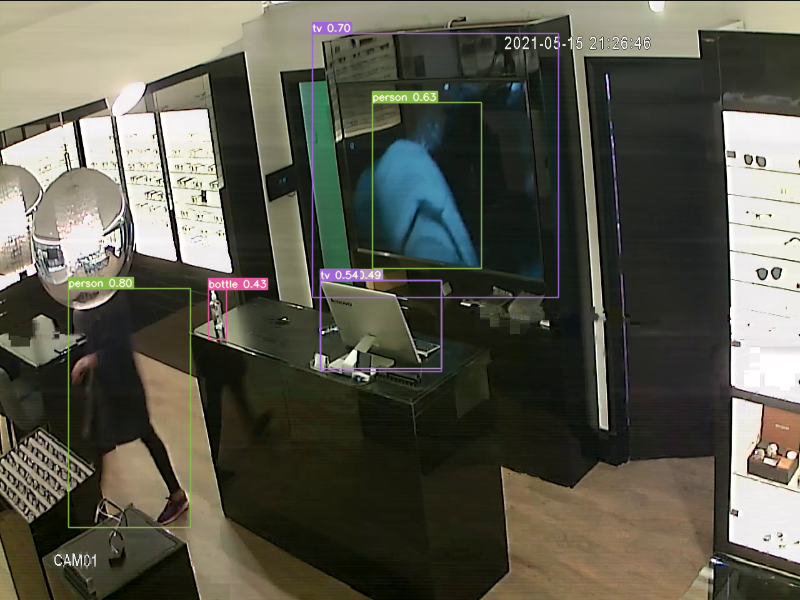

In [8]:
from PIL import Image
Image.open('runs/detect/exp/IMG-1-01.png')

In [9]:
'''# export ONNX for ONNX inference
%cd /content/yolov7/
!python export.py --weights ./yolov7-tiny.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS, 
                     # otherwise it is non-agnostic NMS'''

'# export ONNX for ONNX inference\n%cd /content/yolov7/\n!python export.py --weights ./yolov7-tiny.pt         --grid --end2end --simplify         --topk-all 100 --iou-thres 0.65 --conf-thres 0.35         --img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS, \n                     # otherwise it is non-agnostic NMS'

In [10]:
# show ONNX model
!ls /mnt/PROJECTS/TrackIn/yolov7/trained_weights

yolov7-d6.pt   yolov7-mask.pt  yolov7.torchscript.pt   yolov7-w6.pt
yolov7-e6e.pt  yolov7.onnx     yolov7.torchscript.ptl  yolov7x.pt
yolov7-e6.pt   yolov7.pt       yolov7-w6-pose.pt


In [11]:
# Inference for ONNX model
import cv2
cuda = True
w = "/mnt/PROJECTS/TrackIn/yolov7/trained_weights/yolov7.onnx"
img = cv2.imread('/mnt/PROJECTS/TrackIn/yolov7/inference/images/IMG-1-01.png')

In [12]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

In [13]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs

array([[0.0000000e+00, 5.4739605e+01, 3.1075677e+02, 1.5178528e+02,
        5.0167981e+02, 0.0000000e+00, 8.4779704e-01],
       [0.0000000e+00, 2.5074814e+02, 9.6386566e+01, 4.5405972e+02,
        3.1724124e+02, 6.2000000e+01, 6.6434461e-01],
       [0.0000000e+00, 2.9748016e+02, 1.6117978e+02, 3.8440491e+02,
        2.9464896e+02, 0.0000000e+00, 5.9502912e-01],
       [0.0000000e+00, 2.5599059e+02, 3.0387637e+02, 3.5313367e+02,
        3.7442929e+02, 6.3000000e+01, 5.6839889e-01],
       [0.0000000e+00, 2.5564062e+02, 3.0352512e+02, 3.5275903e+02,
        3.7590555e+02, 6.2000000e+01, 5.1897848e-01],
       [0.0000000e+00, 1.6634315e+02, 3.1100400e+02, 1.8089946e+02,
        3.5042923e+02, 3.9000000e+01, 4.2792985e-01]], dtype=float32)

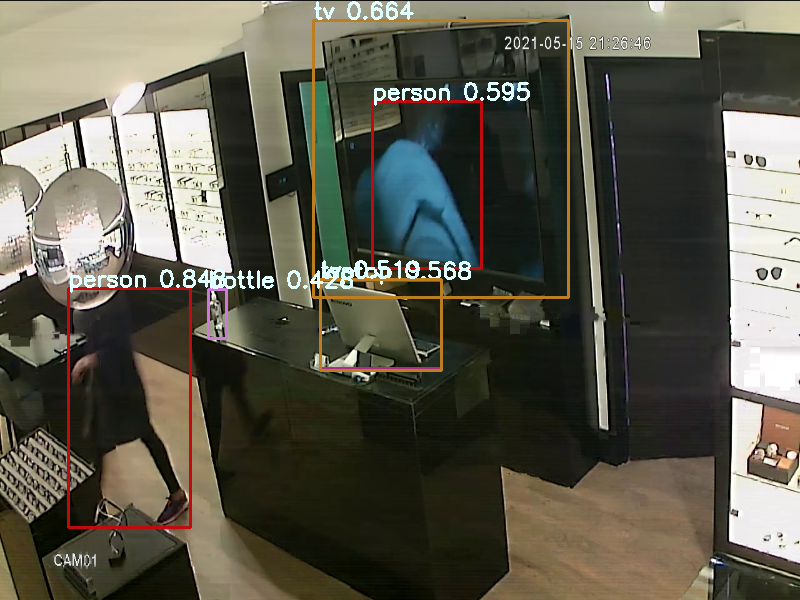

In [14]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])